In [1]:
import json
import re
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import concurrent.futures

# Generate link dataset

In [2]:
with open('../linux-commits-2023-11-12.json') as f:
    all_commits = f.readlines()

In [3]:
# ! git clone git://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git

In [4]:
all_commits_dict_list = []
all_commits_map = {}
for commit in all_commits:
    commit_dict = json.loads(commit)

    # Just a fair idea about multiple-key
    for n in [5, 6, 7, 8, 9, 10, 11, 12]:
        # To cover collisions
        if commit_dict['data']['commit'][0:n] in all_commits_map:
            all_commits_map[commit_dict['data']['commit'][0:n]].append(commit_dict)
        else:
            all_commits_map[commit_dict['data']['commit'][0:n]] = [commit_dict]
    all_commits_dict_list.append(commit_dict)

In [5]:
date_format = '%a %b %d %H:%M:%S %Y %z'
def datesDistance(bfc_date, bic_date):
    bfc_date_formated = datetime.strptime(bfc_date, date_format)
    bic_date_formated = datetime.strptime(bic_date, date_format)
    return bfc_date_formated - bic_date_formated

In [6]:
def commitDistance(bfc_hash, bic_hash):
    distance_raw = subprocess.getoutput("cd linux/ && git rev-list "+bfc_hash+"..."+bic_hash+" | wc -l")
    return int(distance_raw)

In [7]:
def analyzeCornerCases(commit):
    global http_links

    commit_message = commit['data']['message'].replace('"','').replace('(',' ').replace(')',' ')#.lower()
    match = re.search(r"Fixes:[^\S\n]+(\w+)", commit_message)
    if match is not None:
        bic_hash = match.group(1)
    else:
        return None
        
    # There are fixes with a link to Bugzilla/Other sites
    if bic_hash.startswith("http"):
        http_links+=1
        return None

    if bic_hash in [
        'IRQ','NB','SLI','Bug','line','tag',
        'tags','Discovery','discovery','drivers','igt','Bugzilla','bugzilla',
        'correctly','computation','terminate','Configure','addresses',
        'hashes', 'second'
    ]:
        return None

    if bic_hash == "commit":
        match = re.search(r"Fixes:[^\S\n]+commit[^\S\n]+(\b[0-9a-f]{5,40}\b)", commit_message)
        bic_hash = match.group(1)

    elif bic_hash == "Commit":
        match = re.search(r"Fixes:[^\S\n]+Commit[^\S\n]+(\b[0-9a-f]{5,40}\b)", commit_message)
        bic_hash = match.group(1)

    # Double 'Fixes: ' (7 cases)
    elif bic_hash == "Fixes":
        match = re.search("Fixes: Fixes:[^\S\n]+(\b[0-9a-f]{5,40}\b)", commit_message)
        if match is not None:
            bic_hash = match.group(1) 

    # Special format (3 cases)
    elif bic_hash == "linux":
        match = re.search("Fixes: linux-next commit[^\S\n]+(\b[0-9a-f]{5,40}\b)", commit_message)
        if match is not None:
            bic_hash = match.group(1)

    # 77 cases, no commits hashes (manually checked)
    elif len(bic_hash[0:12]) < 6:
        return None

    return bic_hash

In [8]:
def analyzeCommit(commit):
    global errors
    global not_in_git
    global not_sha
    global perfect_samples
    global short_commit_hash
    global corner_cases
    
    try:
        # There are commits without message
        if 'message' not in commit['data']:
            return None

        bic_hash = ""

        # Search: "Fixes: <hash>"
        match = re.search(r"Fixes:[^\S\n]+(\b[0-9a-f]{5,40}\b)", commit['data']['message'])
        if match is not None:
            bic_hash = match.group(1)
            perfect_samples+=1
        else:
            #return None
            # Search: "Fixes <something>"
            bic_hash = analyzeCornerCases(commit)
            if bic_hash is None: return None
            corner_cases+=1

        # Last check, if commit hash not in map, discard it
        if bic_hash[0:12] not in all_commits_map:
            not_in_git+=1
            return None
                
        candidates = all_commits_map[bic_hash[0:12]]

        if len(candidates) > 1:
            print("Collision", bic_hash[0:12], candidates[0]['data']['commit'],candidates[1]['data']['commit'], "BFC: ", commit['data']['commit'])
            return None
        else:
            bic = candidates[0]
        
        delta = datesDistance(commit['data']['CommitDate'],bic['data']['CommitDate'])
        c_distance = commitDistance(commit['data']['commit'], bic['data']['commit'])
        result = {
            'BFC_hash': commit['data']['commit'],
            'BIC_hash':  bic['data']['commit'],
            'BFC_comment': commit['data']['message'].split('\n', 1)[0],
            'BIC_comment': bic['data']['message'].split('\n', 1)[0],
            'daysDistance': delta.days,
            'commitDistance': c_distance
        }
        return result

    except Exception as e:
        errors+=1
        match = re.search("Fixes: (.*)", commit['data']['message'])    
        print("Error matching: ",match.group(0), "BFC:",commit['data']['commit'])
        return None

In [9]:
links = []
errors = 0
corner_cases = 0
http_links = 0
not_in_git = 0
perfect_samples = 0

future_results = []
with concurrent.futures.ThreadPoolExecutor(64) as executor:
    for commit in all_commits_dict_list:
        future = executor.submit(analyzeCommit, commit)
        future_results.append(future)
        
for future in future_results:
    try:
        result = future.result() 
        if result is not None:
            links.append(result)
    except Exception as e:
        print(e)

print("http_links",http_links)
print("not_in_git",not_in_git)
print("perfect_samples",perfect_samples)
print("corner_cases",corner_cases)
print("errors",errors)

Collision 22a5dc 22a5dc0e5e3e8fef804230cd73ed7b0afd4c7bae 22a5dc10e3f8fb8370748ea19dc4e3e1620d8296 BFC:  d7924450e14ea414568563ec01489f77452b00b4
Collision 4f1982 4f198289747f0391bc5a5574279b1791a8ca2d06 4f1982b4e262c45475a91b4253e9bc7f7c991c13 BFC:  3fd61b209977db8a9fe6c44d5a5a7aee7a255f64
Error matching:  Fixes: commit BFC: 7ea38c6c3622bc65279dc6a1fecd28227027fbb5
Error matching:  Fixes: commit 8700e3e7c48A5 ("Add Soft RoCE driver") BFC: e259934d4df7f99f2a5c2c4f074f6a55bd4b1722
http_links 139
not_in_git 1163
perfect_samples 91959
corner_cases 422
errors 2


In [21]:
len(links)

91216

In [22]:
filtered_links = []
for link in links:
    if link['BIC_hash'] != '1da177e4c3f41524e886b7f1b8a0c1fc7321cac2':
        filtered_links.append(link)
len(filtered_links)

90760

## Analysis of distance

In [23]:
df = pd.DataFrame(filtered_links)
df.to_csv('links.csv', index=False)  

In [24]:
df

,BFC_hash,BIC_hash,BFC_comment,BIC_comment,daysDistance,commitDistance
0,c56b097af26cb11c1f49a4311ba538c825666fed,5cedf721a7cdb54e9222133516c916210d836470,mm: list_lru: fix almost infinite loop causing...,list_lru: fix broken LRU_RETRY behaviour,49,3086
1,c511851de162e8ec03d62e7d7feecbdf590d881d,1c441e921201d523b5a6036aea22b0b426bf1af2,"Revert ""epoll: use freezable blocking call""",epoll: use freezable blocking call,171,25649
2,59612d187912750f416fbffe0c00bc0811c54ab5,9745cdb36da83aeec198650b410ca06304cf7928,"Revert ""select: use freezable blocking call""",select: use freezable blocking call,171,25649
3,ab1225901da2d4cd2dcbae6840e93abbef417064,2dc41281b1d1178befe4b76adf817570a7f45ec1,"Revert ""ACPI / hotplug / PCI: Avoid doing too ...",ACPI / hotplug / PCI: Avoid doing too much for...,53,11642
4,6920a1bd037374a632d585de127b6f945199dcb8,3ea67d06e4679a16f69f66f43a8d6ee4778985fc,memcg: remove incorrect underflow check,memcg: add per cgroup writeback pages accounting,49,2422
...,...,...,...,...,...,...
90755,a5035c81847430dfa3482807b07325f29e9e8c09,0d9dab39fbbecfa8f78a4573a2e8eaf982f1207e,fbdev: fsl-diu-fb: mark wr_reg_wa() static,powerpc/5121: fsl-diu-fb: fix issue with re-en...,4848,1031123
90756,ce51e6153f7781bcde0f8bb4c81d6fd85ee422e6,08c9306fc2e32b037ad93127ef784d86699c523a,tracing: fprobe-event: Fix to check tracepoint...,tracing/fprobe-event: Assume fprobe is a retur...,79,31605
90757,f032c53bea6d2057c14553832d846be2f151cfb2,2a588dd1d5d649a183a2ff6fa1b80e870cf821d8,tracing/kprobes: Fix the order of argument des...,tracing: Add kprobe event command generation f...,1380,344728
90758,37de5a80e932f828c34abeaae63170d73930dca3,d08089f649a0cfb2099c8551ac47eef0cc23fdf2,"cifs: Fix encryption of cleared, but unset rq_...",cifs: Change the I/O paths to use an iterator ...,260,75807


### Distance in days

In [25]:
df['daysDistance'].describe()

count    90760.000000
mean       646.141516
std       1003.671112
min          0.000000
25%         45.000000
50%        203.000000
75%        795.000000
max       6697.000000
Name: daysDistance, dtype: float64

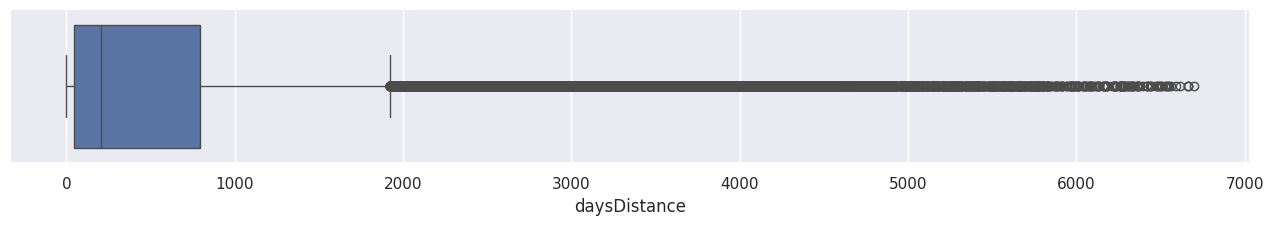

In [26]:
#df.boxplot(column=['daysDistance'])
sns.set(rc={"figure.figsize":(16, 2)})
sns.boxplot(
    x=df['daysDistance'], 
)
plt.show()

### Distance in commits

In [27]:
df['commitDistance'].describe()

count    9.076000e+04
mean     1.402596e+05
std      2.062567e+05
min      1.000000e+00
25%      1.376500e+04
50%      4.613550e+04
75%      1.813582e+05
max      1.214794e+06
Name: commitDistance, dtype: float64

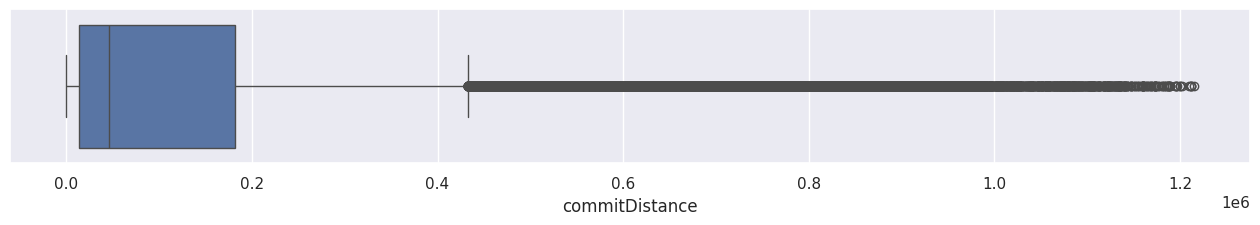

In [28]:
#df.boxplot(column=['daysDistance'])
sns.set(rc={"figure.figsize":(16, 2)})
sns.boxplot(
    x=df['commitDistance'], 
)
plt.show()

## Rare cases
- No commit message: https://github.com/torvalds/linux/commit/7b7abfe3dd81d659a0889f88965168f7eef8c5c6
- No exist in repository (but in GitHub): https://github.com/torvalds/linux/commit/54fe26a900bc528f3df1e4235cb6b9ca5c6d4dc2
- No exist (even in GitHub): 21d2202158e9